- Handling warnings

In [45]:
import warnings
warnings.filterwarnings("ignore")

- Load modules

In [46]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import (silhouette_score, davies_bouldin_score, calinski_harabasz_score)
from sklearn.cluster import (KMeans, AffinityPropagation, AgglomerativeClustering, Birch, HDBSCAN,
                             BisectingKMeans, DBSCAN, MeanShift, MiniBatchKMeans, OPTICS, SpectralClustering)
import numpy as np
import json
from common_funtions import *

- Defining auxiliar functions

In [47]:
def get_profile(row, label_columns):
    active_labels = [col for col in label_columns if row[col] == 1]
    return '-'.join(active_labels)

- Loading and preparing data for word/sentence clustering

In [48]:
df_data = pd.read_csv("../raw_data/curated_PrimaryOdor.csv")
df_data.head(5)

,standardized_smiles,odor_2,odor_3,odor_4,odor_5,odor_6,odor_7,odor_8,odor_9,odor_10,...,odor_28,odor_29,odor_30,odor_31,odor_32,odor_33,odor_34,odor_35,odor_36,odor_37
0,BrC=Cc1ccccc1,Fragrant,Vegetation,Green,Fruity,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,C#CC(C)(O)CCC=C(C)C,Dry,Ambrosial,Woody,Waxy,Resinous,Grassy,Sweet,Fragrant,Plants,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,C#CC1(OC(C)=O)CCCCC1,Dry,Vegetation,Aromatic,Woody,Nutty,Resinous,Grassy,Other,Fragrant,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,C#CC1(OC(C)=O)CCCCC1C(C)CC,Dry,Vegetation,Woody,Soft oriental,Resinous,Grassy,Mossy woods,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,C#CCO,Fragrant,Floral,Nature,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
df_data.columns

Index(['standardized_smiles', 'odor_2', 'odor_3', 'odor_4', 'odor_5', 'odor_6',
       'odor_7', 'odor_8', 'odor_9', 'odor_10', 'odor_11', 'odor_12',
       'odor_13', 'odor_14', 'odor_15', 'odor_16', 'odor_17', 'odor_18',
       'odor_19', 'odor_20', 'odor_21', 'odor_22', 'odor_23', 'odor_24',
       'odor_25', 'odor_26', 'odor_27', 'odor_28', 'odor_29', 'odor_30',
       'odor_31', 'odor_32', 'odor_33', 'odor_34', 'odor_35', 'odor_36',
       'odor_37'],
      dtype='object')

- Get Unique odors

In [50]:
list_unique_odors = []

for i in range(2, 38):
    column = f"odor_{i}"
    unique_values = df_data[column].unique().tolist()
    unique_values = [str(value).replace(" ", "_").lower() for value in unique_values]
    list_unique_odors += unique_values

list_unique_odors = list(set(list_unique_odors))
len(list_unique_odors)

114

- Loading pre-trained model from sentenceTransformer: See https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2 for more details

In [51]:
model = SentenceTransformer('all-MiniLM-L6-v2')

- Get embeddings for applying clustering strategies

In [52]:
matrix_for_clustering = []
list_words_for_clustering = []

for word in list_unique_odors:
    if str(word) != "nan":
        vector = model.encode(word)
        matrix_for_clustering.append(vector)
        list_words_for_clustering.append(word)

header = [f"p_{i+1}" for i in range(len(matrix_for_clustering[0]))]
df_for_clustering = pd.DataFrame(data=matrix_for_clustering, columns=header)
df_for_clustering['word'] = list_words_for_clustering
df_for_clustering

,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,p_9,p_10,...,p_376,p_377,p_378,p_379,p_380,p_381,p_382,p_383,p_384,word
0,-0.032141,0.020763,-0.077700,-0.026563,-0.032642,-0.001619,0.120775,0.085451,-0.058151,-0.000998,...,0.013765,-0.091376,-0.099034,-0.007136,-0.023587,0.101959,-0.013005,0.013327,0.025430,balsamic
1,0.010715,-0.096496,0.011653,0.097514,0.002283,0.006891,0.060037,0.075729,-0.050742,-0.066648,...,0.006473,0.060644,-0.104962,-0.009434,-0.010357,0.057139,-0.040455,0.162130,-0.033535,dairy
2,-0.065661,0.030892,0.041472,0.030980,0.067291,-0.104566,0.105631,-0.084446,-0.098060,0.028352,...,0.006336,0.085916,0.048903,0.009996,-0.027162,0.034144,-0.022327,0.061069,-0.074753,cleaning_materials
3,-0.132370,-0.015455,0.014970,0.063380,-0.010077,-0.107205,0.093927,-0.054317,0.088469,-0.099326,...,-0.020577,0.002439,-0.041965,-0.033732,0.035192,0.081102,-0.066734,-0.031622,-0.027540,mol
4,0.010484,0.066375,0.000973,0.018313,-0.010065,-0.051002,0.122491,-0.038181,0.015304,-0.036745,...,-0.096726,0.056686,0.034029,0.075668,0.013379,0.181473,-0.008606,0.037948,0.001947,burnt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,-0.034320,0.013495,-0.040503,-0.002655,-0.030003,-0.039077,0.137848,-0.047383,-0.027486,-0.034335,...,0.006494,0.028826,0.087595,0.013796,-0.018000,0.138361,0.050317,0.054646,-0.017744,smokey
109,-0.026963,0.018918,-0.054494,0.083278,0.015622,-0.014131,0.039484,-0.018671,0.025543,-0.016384,...,0.036814,0.139544,-0.012439,-0.028222,0.064492,-0.078370,0.062815,0.089643,0.033330,vegetables
110,-0.028281,-0.038063,-0.038194,0.016972,0.002726,-0.050792,0.020560,0.040499,-0.103043,0.054075,...,-0.033177,0.025759,0.005005,0.030660,0.036596,0.077587,0.004996,0.049031,-0.026469,alliaceous
111,-0.104196,-0.034464,-0.018702,0.081501,-0.014972,0.048060,0.042487,0.003006,0.036114,-0.077364,...,-0.016834,0.005153,0.079056,0.006228,-0.057040,-0.032130,0.004075,-0.039471,0.019753,spices


- Loading hyperparameter config for clustering

In [53]:
with open('../config/hyperparameter_unsupervised_methods.json', 'r') as config:
    hyperparameter_configs = json.load(config)

- Applying clustering algorithms

In [54]:
list_configs = [
    (AgglomerativeClustering, "AgglomerativeClustering", hyperparameter_configs['AgglomerativeClustering']),
    (HDBSCAN, "HDBSCAN", hyperparameter_configs['HDBSCAN']),
    (OPTICS, "OPTICS", hyperparameter_configs['OPTICS']),
    (SpectralClustering, "SpectralClustering", hyperparameter_configs['SpectralClustering']),
    (MeanShift, "MeanShift", hyperparameter_configs['MeanShift']),
    (BisectingKMeans, "BisectingKMeans", hyperparameter_configs['BisectingKMeans']),
    (Birch, "Birch", hyperparameter_configs['Birch']),
    (KMeans, "Kmeans", hyperparameter_configs['Kmeans']),
    (DBSCAN, "DBSCAN", hyperparameter_configs['DBSCAN']),
    (AffinityPropagation, "AffinityPropagation", hyperparameter_configs['AffinityPropagation']),
]

In [55]:
list_models = {}
list_performances = []

for config_values in list_configs:
    model, performances = apply_clustering(
        config_values[0], 
        df_for_clustering.drop(columns=['word']), 
        config_values[1], 
        **config_values[2])
    
    list_models.update({config_values[1]: model})
    list_performances.append(performances)

performance_algorithms = pd.DataFrame(list_performances)
performance_algorithms

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

,name_method,silhouette_score,davies_bouldin_score,calinski_harabasz_score
0,AgglomerativeClustering,0.032275,3.245384,3.110125
1,HDBSCAN,NaN,NaN,NaN
2,OPTICS,-0.012642,2.782425,2.205191
3,SpectralClustering,0.043048,2.970780,3.233481
4,MeanShift,NaN,NaN,NaN
5,BisectingKMeans,0.011310,3.795979,2.343606
6,Birch,0.028668,4.374105,3.851480
7,Kmeans,0.016368,3.667356,2.426442
8,DBSCAN,NaN,NaN,NaN
9,AffinityPropagation,0.046436,2.493189,2.596549


In [56]:
performance_algorithms.sort_values(by="silhouette_score", ascending=False)

,name_method,silhouette_score,davies_bouldin_score,calinski_harabasz_score
9,AffinityPropagation,0.046436,2.493189,2.596549
3,SpectralClustering,0.043048,2.970780,3.233481
0,AgglomerativeClustering,0.032275,3.245384,3.110125
6,Birch,0.028668,4.374105,3.851480
7,Kmeans,0.016368,3.667356,2.426442
5,BisectingKMeans,0.011310,3.795979,2.343606
2,OPTICS,-0.012642,2.782425,2.205191
1,HDBSCAN,NaN,NaN,NaN
4,MeanShift,NaN,NaN,NaN
8,DBSCAN,NaN,NaN,NaN


In [57]:
pd.Series(list_models['SpectralClustering'].labels_).value_counts()

3    23
6    22
0    21
1    18
4    12
2    11
7     4
5     2
Name: count, dtype: int64

- Apply dimensionality reduction techniques and make visualization

In [58]:
data_transformed = TSNE(random_state=42).fit_transform(df_for_clustering.drop(columns=['word']))
df_tsne = pd.DataFrame(data=data_transformed, columns=["t-SNE 1", "t-SNE 2"])
df_tsne['cluster'] = list_models['SpectralClustering'].labels_
df_tsne['cluster'] = df_tsne['cluster'].astype(str)

<Axes: xlabel='t-SNE 1', ylabel='t-SNE 2'>

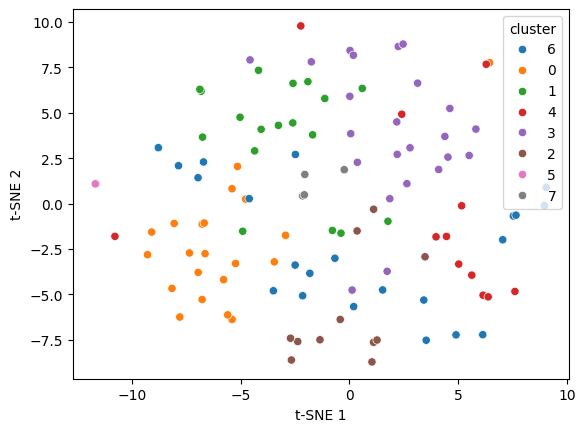

In [59]:
sns.scatterplot(data=df_tsne, x="t-SNE 1", y="t-SNE 2", hue="cluster")

- Checking the content per clustering

In [60]:
useful_columns = []
for element in list_models:
    if element not in ['HDBSCAN', 'MeanShift', 'DBSCAN', 'OPTICS']:
        df_for_clustering[element] = list_models[element].labels_
        useful_columns.append(element)

In [61]:
df_for_clustering

,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,p_9,p_10,...,p_382,p_383,p_384,word,AgglomerativeClustering,SpectralClustering,BisectingKMeans,Birch,Kmeans,AffinityPropagation
0,-0.032141,0.020763,-0.077700,-0.026563,-0.032642,-0.001619,0.120775,0.085451,-0.058151,-0.000998,...,-0.013005,0.013327,0.025430,balsamic,2,6,4,2,5,9
1,0.010715,-0.096496,0.011653,0.097514,0.002283,0.006891,0.060037,0.075729,-0.050742,-0.066648,...,-0.040455,0.162130,-0.033535,dairy,3,0,2,0,6,8
2,-0.065661,0.030892,0.041472,0.030980,0.067291,-0.104566,0.105631,-0.084446,-0.098060,0.028352,...,-0.022327,0.061069,-0.074753,cleaning_materials,1,1,1,0,0,3
3,-0.132370,-0.015455,0.014970,0.063380,-0.010077,-0.107205,0.093927,-0.054317,0.088469,-0.099326,...,-0.066734,-0.031622,-0.027540,mol,2,4,1,1,7,3
4,0.010484,0.066375,0.000973,0.018313,-0.010065,-0.051002,0.122491,-0.038181,0.015304,-0.036745,...,-0.008606,0.037948,0.001947,burnt,1,1,1,1,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,-0.034320,0.013495,-0.040503,-0.002655,-0.030003,-0.039077,0.137848,-0.047383,-0.027486,-0.034335,...,0.050317,0.054646,-0.017744,smokey,1,3,5,1,2,7
109,-0.026963,0.018918,-0.054494,0.083278,0.015622,-0.014131,0.039484,-0.018671,0.025543,-0.016384,...,0.062815,0.089643,0.033330,vegetables,3,0,6,2,3,8
110,-0.028281,-0.038063,-0.038194,0.016972,0.002726,-0.050792,0.020560,0.040499,-0.103043,0.054075,...,0.004996,0.049031,-0.026469,alliaceous,2,6,3,1,7,13
111,-0.104196,-0.034464,-0.018702,0.081501,-0.014972,0.048060,0.042487,0.003006,0.036114,-0.077364,...,0.004075,-0.039471,0.019753,spices,4,0,6,2,3,8


In [62]:
dict_with_words = []

for column in useful_columns:
    labels = df_for_clustering[column].unique()
    list_words = []
    for label in labels:
        words = df_for_clustering[df_for_clustering[column] == label]['word'].tolist()
        words = ', '.join(words)
        dict_value = {"label": str(label), "words": words}
        list_words.append(dict_value)
    dict_cluster = {
        "cluster":column,
        "number_of_labels":int(len(labels)),
        "content" : list_words
    }
    dict_with_words.append(dict_cluster)

with open("../results/summary_word_clustering.json", "w", encoding="utf-8") as f:
    json.dump(dict_with_words, f, indent=4, ensure_ascii=False)

- Next step: Exploring relation of clusters per compound. We will select just an option of the generated clusters and then we will apply the methodology.

In [63]:
df_for_clustering

,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,p_9,p_10,...,p_382,p_383,p_384,word,AgglomerativeClustering,SpectralClustering,BisectingKMeans,Birch,Kmeans,AffinityPropagation
0,-0.032141,0.020763,-0.077700,-0.026563,-0.032642,-0.001619,0.120775,0.085451,-0.058151,-0.000998,...,-0.013005,0.013327,0.025430,balsamic,2,6,4,2,5,9
1,0.010715,-0.096496,0.011653,0.097514,0.002283,0.006891,0.060037,0.075729,-0.050742,-0.066648,...,-0.040455,0.162130,-0.033535,dairy,3,0,2,0,6,8
2,-0.065661,0.030892,0.041472,0.030980,0.067291,-0.104566,0.105631,-0.084446,-0.098060,0.028352,...,-0.022327,0.061069,-0.074753,cleaning_materials,1,1,1,0,0,3
3,-0.132370,-0.015455,0.014970,0.063380,-0.010077,-0.107205,0.093927,-0.054317,0.088469,-0.099326,...,-0.066734,-0.031622,-0.027540,mol,2,4,1,1,7,3
4,0.010484,0.066375,0.000973,0.018313,-0.010065,-0.051002,0.122491,-0.038181,0.015304,-0.036745,...,-0.008606,0.037948,0.001947,burnt,1,1,1,1,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,-0.034320,0.013495,-0.040503,-0.002655,-0.030003,-0.039077,0.137848,-0.047383,-0.027486,-0.034335,...,0.050317,0.054646,-0.017744,smokey,1,3,5,1,2,7
109,-0.026963,0.018918,-0.054494,0.083278,0.015622,-0.014131,0.039484,-0.018671,0.025543,-0.016384,...,0.062815,0.089643,0.033330,vegetables,3,0,6,2,3,8
110,-0.028281,-0.038063,-0.038194,0.016972,0.002726,-0.050792,0.020560,0.040499,-0.103043,0.054075,...,0.004996,0.049031,-0.026469,alliaceous,2,6,3,1,7,13
111,-0.104196,-0.034464,-0.018702,0.081501,-0.014972,0.048060,0.042487,0.003006,0.036114,-0.077364,...,0.004075,-0.039471,0.019753,spices,4,0,6,2,3,8


In [64]:
df_filter = df_for_clustering[['word', 'SpectralClustering']]
df_filter["SpectralClustering"].value_counts().sort_index()

SpectralClustering
0    21
1    18
2    11
3    23
4    12
5     2
6    22
7     4
Name: count, dtype: int64

In [65]:
matrix_data_pivote = []

for index in df_data.index:
    smile = [df_data["standardized_smiles"][index]]

    row_odor = [0 for i in range(len(df_filter["SpectralClustering"].unique()))]

    odor_list = [df_data[column][index].replace(" ", "_").lower() for column in df_data.columns if column != "standardized_smiles" and str(df_data[column][index]) != "nan"]
    
    for word in odor_list:
        filter_cluster_values = df_filter[df_filter["word"] == word]
        filter_cluster_values.reset_index(inplace=True)
        cluster_id = int(filter_cluster_values["SpectralClustering"][0])
        row_odor[cluster_id] = 1
    
    row = smile + row_odor
    matrix_data_pivote.append(row)

header_clusters = [f"label_{i}" for i in range(len(df_filter["SpectralClustering"].unique()))]
header_clusters.insert(0, "standardized_smiles")

df_pivote = pd.DataFrame(data=matrix_data_pivote, columns=header_clusters)
df_pivote

,standardized_smiles,label_0,label_1,label_2,label_3,label_4,label_5,label_6,label_7
0,BrC=Cc1ccccc1,0,1,1,1,0,0,0,0
1,C#CC(C)(O)CCC=C(C)C,0,1,1,1,1,0,1,0
2,C#CC1(OC(C)=O)CCCCC1,0,1,1,1,1,0,1,0
3,C#CC1(OC(C)=O)CCCCC1C(C)CC,0,1,1,0,1,0,1,0
4,C#CCO,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
3419,c1coc(Cc2coc(Cc3ccco3)c2)c1,0,0,1,1,0,0,0,0
3420,c1coc(Cn2cccc2)c1,1,1,1,1,1,1,1,0
3421,c1csc(SSc2cccs2)c1,1,1,0,1,1,1,1,1
3422,c1cscn1,1,1,0,1,0,1,1,0


In [66]:
df_pivote["number_of_profiles"] = df_pivote.sum(numeric_only=True, axis=1)
df_pivote

,standardized_smiles,label_0,label_1,label_2,label_3,label_4,label_5,label_6,label_7,number_of_profiles
0,BrC=Cc1ccccc1,0,1,1,1,0,0,0,0,3
1,C#CC(C)(O)CCC=C(C)C,0,1,1,1,1,0,1,0,5
2,C#CC1(OC(C)=O)CCCCC1,0,1,1,1,1,0,1,0,5
3,C#CC1(OC(C)=O)CCCCC1C(C)CC,0,1,1,0,1,0,1,0,4
4,C#CCO,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
3419,c1coc(Cc2coc(Cc3ccco3)c2)c1,0,0,1,1,0,0,0,0,2
3420,c1coc(Cn2cccc2)c1,1,1,1,1,1,1,1,0,7
3421,c1csc(SSc2cccs2)c1,1,1,0,1,1,1,1,1,7
3422,c1cscn1,1,1,0,1,0,1,1,0,5


In [67]:
df_pivote.to_csv("../results/pivote_dataset.csv", index=False)